# Analysis of precipitation data using extreme value methods

This notebook demonstrates several methods for assessing the frequency of extreme precipitation events.

For reference, here is a paper using extreme value techniques to study rainfall in Brazil:

https://link.springer.com/article/10.1007/s42452-020-03199-8

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import genpareto, genextreme
from scipy.optimize import minimize
from scipy.special import gamma
from pathlib import Path

Below we define several functions that implement methods for extreme value analysis.  After defining these functions, we can use them to analyze the precipitation data.

In [60]:
def tail_shape(z, p0=0.1, family="powerlaw"):
    """
    Returns values x, p such that the slope of p on x estimates the
    shape parameter (tail index) of a distribution with power-law
    tails (if family='powerlaw'), or the rate parameter of a
    distribution with exponential tails (if family='exponential').
    The upper p0 fraction of the data in z are used to produce (x, p).
    The returned values in x are the order statistics of z in the
    exponential case, and the log order statistics of z in the powerlaw
    case. The returned values in p are derived from probability
    points.  Scatterplot p against x to get a visualization of the
    tail shape.
    """

    if family not in ["exponential", "powerlaw"]:
        raise ValueError("Unknown family %s" % family)

    z = z.copy()
    p = 1 - p0
    z = np.asarray(z)
    z.sort()
    n = len(z)
    m = int(np.around(p*n))
    x = z[m-1:]
    if family == "powerlaw":
        x = np.log(x + 1e-6)
    p = np.log(1 - np.arange(m, n+1) / (n+1))
    return x, p

In [61]:
def fit_tail_reg(x, ax, p0=0.99, family="powerlaw"):
    """
    Use least squares regression in the upper 'p0' fraction of the right
    tail of a quantile plot to estimate the shape parameter, and add the
    best fit line to the plot in axes 'ax'.
    """

    x, p = tail_shape(x, p0=p0, family=family)

    ax.plot(x, p, color="orange")

    # Estimate the tail index using a least squares fit to the order
    # statistics.
    alpha_hat = -np.cov(p, x)[0, 1] / np.var(x)
    icept = p.mean() + alpha_hat*x.mean()

    # The coordinates of the best-fit line
    xx = np.asarray([x.min(), x.max()])
    yy = icept - alpha_hat*xx

    ax.plot(xx, yy, color="purple")

    return icept, alpha_hat

In [62]:
def hill(z, k=200):
    """
    Estimate the tail index of a distribution with poower law tails using Hill's
    estimator, based on the upper k order statistics.
    """

    z = np.sort(z)
    z = np.log(z[-k:])
    return 1 / (z[1:] - z[0]).mean()

In [63]:
def plot_hill(z):
    """
    Plot the Hill estimate of the tail index for a range
    of values of the tuning parameter k.
    """

    kv = np.arange(20, 501, 5)
    ta = np.asarray([hill(z, k=k) for k in kv])

    plt.clf()
    ax = plt.axes()
    plt.grid(True)
    ax.set_title("Hill estimate of the tail index")
    ax.plot(kv, ta)
    ax.set_xlabel("k", size=16)
    ax.set_ylabel("Tail index estimate", size=16)
    ax.set_ylim(2.5, 5)
    plt.show()

In [64]:
def fit_gev(x):
    """
    Fit a generalized extreme value distribution (GEV) using maximum likelihood
    estimation to the data in 'x'. Probability weighted moments are used to obtain
    starting values:
    https://www.stat.cmu.edu/technometrics/80-89/VOL-27-03/v2703251.pdf
    
    The returned frozen GEV distribution follows the scipy parameterization:
    
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.genextreme.html
    
    Note that this differs from another common parameterization, which is the one
    used on Wikipedia:
    
    https://en.wikipedia.org/wiki/Generalized_extreme_value_distribution
    """

    x = np.sort(x)
    n = len(x)

    # Plotting positions
    pp = np.arange(1/2, n + 1/2) / n

    # Calculate the first three probability weighted moments
    b = np.zeros(3)
    for r in range(3):
        b[r] = np.dot(pp**r, x) / n

    # The PWM estimator of Hoskins et al.
    c = (2*b[1] - b[0]) / (3*b[2] - b[0])  - np.log(2) / np.log(3)
    shape = 7.8590*c + 2.9554*c**2
    scale = (2*b[1] - b[0]) * shape / (gamma(1 + shape) * (1 - 1/2**shape))
    loc = b[0] + scale*(gamma(1 + shape) - 1) / shape
    ge = genextreme(shape, loc=loc, scale=scale)
    
    # Get the MLE
    def f(par):
        shape, loc, logscale = par
        d = genextreme(shape, loc=loc, scale=np.exp(logscale))
        return -d.logpdf(x).sum()

    logscale = np.log(scale)
    x0 = np.asarray([shape, loc, logscale])
    rr = minimize(f, x0, method="powell")
    shape, loc, logscale = rr.x
    ge = genextreme(shape, loc=loc, scale=np.exp(logscale))
    return ge

In [65]:
def block_max(dx):
    """
    Calculate the maximum precipitation value for each complete year,
    and fit a generalized extreme value (GEV) distribution to the
    data.  Then use the fitted model to calculate returns for a sequence
    of time horizons, and create a QQ plot to assess goodness-of-fit.
    
    Returns the fitted generalized extreme value distribution model.
    """

    # Get the annual maximum for all complete years
    dx = dx.query("year > 1958 & year < 2023")
    yrmx = dx.groupby("year")["PRCP"].agg(np.max)
    
    # Fit a generalized extreme value distribution to the block maxima.
    gev = fit_gev(yrmx)

    # m-observation returns
    rr = pd.DataFrame({"Years": [10, 100, 500, 1000]})
    rr["Return"] = gev.ppf(1 - 1/rr.Years)
    print(rr)

    # Make a QQ plot to assess goodness of fit of the GEV model
    z = np.sort(yrmx)
    n = len(z)
    pp = np.arange(1, n + 1) / (n + 1)
    qq = gev.ppf(pp)

    plt.clf()
    ax = plt.axes()
    plt.grid(True)
    ax.plot(qq, z)
    ax.set_xlabel("GEV quantiles")
    ax.set_ylabel("Order statistics")
    ax.set_title("GEV fit to annual maxima")
    plt.show()

    return gev

In [66]:
def gp_estimate(z):
    """
    Estimate the parameters of a generalized Pareto distribution
    using the empirical Bayes method of Zhang and Stephens.
    https://www.jstor.org/stable/pdf/40586625.pdf
    
    Returns the fitted generalized Pareto model. See the link below for
    details about how the distribution is parameterized:
    
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.genpareto.html
    """

    # The prior is discrete and data-adaptive, based on these parameters
    z = np.sort(z)
    n = len(z)
    xstar = z[int(np.round(n/4 + 0.5))]
    m = np.ceil(20 + np.sqrt(n))
    xmax = z.max()

    # The grid on which the prior is supported
    jj = np.arange(1, m+1)
    tgrid = 1/xmax + (1 - np.sqrt(m/(jj-0.5))) / (3 * xstar)

    # The profile log likelihood function
    def profile(theta):
        k = -np.log(1 - theta*z).mean()
        return n*(np.log(theta/k) + k - 1)

    # The posterior distribution
    ltg = np.asarray([profile(t) for t in tgrid])
    ltg -= ltg.max()
    Ltg = np.exp(ltg)
    Ltg /= Ltg.sum()
    
    # The posterior is a generalized Pareto with these parameters
    theta_hat = np.dot(Ltg, tgrid)
    k_hat = -np.log(1 - theta_hat*z).mean()
    scale_hat = k_hat / theta_hat

    # Return the posterior distribution
    return genpareto(-k_hat, scale=scale_hat)

In [67]:
def eb_analysis(z, thresh):
    """
    Fit a generalized Pareto model to the exceedances derived from z,
    using empirical Bayes estimation, and create a QQ plot to assess
    the goodness-of-fit.
    """

    # Exceedances
    z = z[z > thresh] - thresh

    # Empirical Bayes estimate of Zhang and Stephens.
    eb = gp_estimate(z)

    n = len(z)
    pp = np.linspace(1/2, n - 1/2, n) / n # plotting positions
    qq = eb.ppf(pp)
    z = np.sort(z)

    # QQ plot to show goodness of fit
    plt.clf()
    ax = plt.axes()
    plt.grid(True)
    ax.set_title("EB: shape=%.3f scale=%.3f, tail=%.2f" % (eb.args[0], eb.kwds["scale"], 1/eb.args[0]))
    ax.plot(qq, z)
    plt.xlabel("GP quantiles (EB)", size=16)
    plt.ylabel("Order statistics", size=16)
    plt.show()

    return eb

In [68]:
def plot_tails(z, p0, thresh, family):
    """
    Plot the tail of the estimated CDF based on the upper 'p0' proportion of the data in z.  
    If family is 'exponential' use a semi-log plot, if family is 'powerlaw' use a log/log plot.
    """

    n = len(z)

    # The number of selected observations
    m = int(np.around(p0*n))

    xlabel = "log Q(p)" if family == "powerlaw" else "Q(p)"

    plt.clf()
    ax = plt.axes()
    plt.grid(True)
    icept, alpha = fit_tail_reg(z, ax, p0=p0, family=family)
    ax.set_xlabel(xlabel, size=16)
    ax.set_ylabel("log(1-p)", size=16)
    ti = "%s model, threshold=%.1f, top %.1f%% (n=%d), alpha=%.3f" %\
           (family.title(), thresh, 100*p0, m, alpha)
    plt.title(ti)
    plt.show()

In [69]:
def check_gp_estimate(shape, scale, thresh, n=100000):
    z = genpareto.rvs(shape, scale=scale, size=n)
    z = z[z > thresh] - thresh
    eb = gp_estimate(z)
    return eb, z

In [70]:
def mobs_return(z, mr, thresh, family="exponential", gp=None):
    """
    Calculate the m-observation returns for the data in z, using either
    an exponential or generalized Pareto model.
    """

    z = np.asarray(z)
    n = len(z)

    # Select only extreme values and translate back to the origin
    ix = np.flatnonzero(z >= thresh)
    q = len(ix) / n # proportion of values exceeding the threshold
    z = z[ix]
    z -= thresh

    pr = 1 - 1 / (q * mr)

    if family == "exponential":
        mn = z.mean()
        print("Mean = %.2f" % mn)
        m0 = thresh - mn*np.log(1 - pr)
    elif family == "generalizedpareto":
        print("Shape=%.2f" % eb.args[0])
        print("Scale=%.2f" % eb.kwds["scale"])
        m0 = thresh + gp.ppf(pr)
    else:
        raise ValueError("!!")

    return m0

In [71]:
import os
import pandas as pd

# Download the NCDC data, also available from this site:
#  https://www.ncei.noaa.gov/access/search/data-search/daily-summaries

base_url = "https://www.ncei.noaa.gov/data/daily-summaries/access"

target_dir = "/Users/keanmingtan/Dropbox/Teaching/Umich2019/Fall2025/STATS504/lecturenotes/week4/"

files = ["USW00094847.csv", "USW00012839.csv",]

for f in files:
    df = pd.read_csv(os.path.join(base_url, f))
    df.to_csv(os.path.join(target_dir, f + ".gz"))

<ipython-input-71-d868ad613a28>:14: DtypeWarning: Columns (17,19,21,23,25,27,29,31,33,35,39,41,43,45,49,51,53,55,57,59,61,63,65,67,69,71,85,91,93,95,97,99,101,103,105,107,109,111,113,115) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(base_url, f))
<ipython-input-71-d868ad613a28>:14: DtypeWarning: Columns (17,19,21,23,25,27,29,31,37,39,41,43,45,49,51,53,55,57,59,61,63,65,73,75,77,79,83,85,87,89,91,93,95,97) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(base_url, f))


Choose a specific location to analyze.

In [72]:
fname = "USW00094847.csv" # Detroit
#fname = "USW00012839.csv" # Miami

In [73]:
df = pd.read_csv(("%s.gz" % fname), parse_dates=["DATE"],
                 low_memory=False)
df.head()


,Unnamed: 0,STATION,DATE,LATITUDE,LONGITUDE,ELEVATION,NAME,PRCP,PRCP_ATTRIBUTES,SNOW,...,WT19,WT19_ATTRIBUTES,WT21,WT21_ATTRIBUTES,WT22,WT22_ATTRIBUTES,WV03,WV03_ATTRIBUTES,WV20,WV20_ATTRIBUTES
0,0,USW00094847,1942-08-01,42.23113,-83.33121,191.9,"DETROIT METRO AIRPORT, MI US",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,USW00094847,1942-08-02,42.23113,-83.33121,191.9,"DETROIT METRO AIRPORT, MI US",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,USW00094847,1942-08-03,42.23113,-83.33121,191.9,"DETROIT METRO AIRPORT, MI US",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,USW00094847,1942-08-04,42.23113,-83.33121,191.9,"DETROIT METRO AIRPORT, MI US",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,USW00094847,1942-08-05,42.23113,-83.33121,191.9,"DETROIT METRO AIRPORT, MI US",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We only care about these two variables, which must not be missing.  "PRCP" is the 24-hour rainfall total, recorded in tenths of a millimeter.

In [74]:
df = df[["DATE", "PRCP"]].dropna()

Add a year variable for block-maxima (GEV) analyses

In [75]:
df["year"] = df["DATE"].dt.year

Convert precipitation to millimeters

In [76]:
df["PRCP"] /= 10

The data may be sorted already, but sort again just to be sure

In [77]:
df = df.sort_values(by="DATE")

Display the first few rows of data.

In [78]:
df.head()

,DATE,PRCP,year
1515,1958-12-01,0.0,1958
1516,1958-12-02,0.0,1958
1517,1958-12-03,0.0,1958
1518,1958-12-04,0.0,1958
1519,1958-12-05,1.3,1958


Use this threshold (units are mm) for calculating exceedances

In [79]:
thresh = 10.0
(df["PRCP"] >= thresh).mean()

0.07327780740983876

Plot the data as a histogram.  A histogram is not useful for studying extreme values.

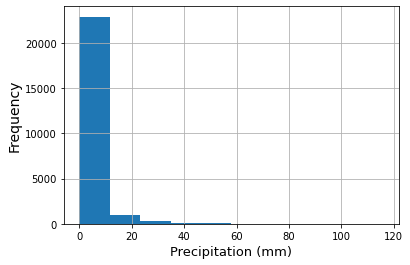

In [84]:
plt.clf()
plt.grid(True)
plt.hist(df["PRCP"])
plt.xlabel("Precipitation (mm)", size=13)
plt.ylabel("Frequency", size=14)
plt.show()

Plot the data as an (empirical) CDF.  This is not a very helpful approach for judging the structure of the tail of a probability distribution.

Text(0, 0.5, 'Cumulative probability')

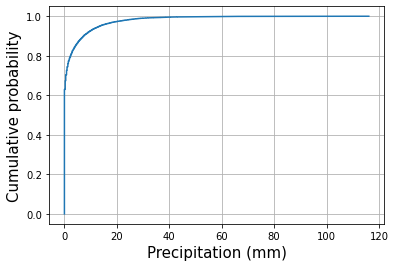

In [85]:
plt.clf()
plt.grid(True)
x = np.sort(df["PRCP"])
p = np.linspace(0, 1, len(x))
plt.plot(x, p, "-")
plt.xlabel("Precipitation (mm)", size=15)
plt.ylabel("Cumulative probability", size=15)

Plot the data as an (empirical) complementary CDF (also known as the ccdf or survival function)

## What Is a Complementary CDF?

The **complementary cumulative distribution function** — also known as the **survival function** — is defined as:

\[
CCDF(x) = P(X > x) = 1 - F(x)
\]

Where:
-  F(x)  is the **cumulative distribution function (CDF)**,
-  P(X > x)  is the probability that a random variable  X  takes on a value **greater than**  x .

---

## Why Plot a Complementary CDF?

Plotting the complementary CDF is particularly useful when:

### 🔹 Tail Analysis
- You care about **rare or extreme events** (e.g., outliers, failures, heavy tails in distributions like **Pareto** or **power-law**).

### 🔹 Clarity in Heavy-Tailed Data
- The complementary CDF helps you see how many values lie **above a certain threshold** — especially useful when data spans several orders of magnitude.


Text(0, 0.5, 'Complementary cumulative probability')

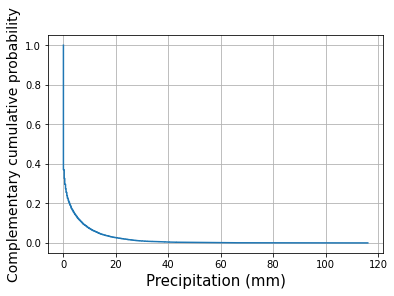

In [86]:
plt.clf()
plt.grid(True)
x = np.sort(df["PRCP"])
p = np.linspace(0, 1, len(x))
plt.plot(x, 1 - p, "-")
plt.xlabel("Precipitation (mm)", size=15)
plt.ylabel("Complementary cumulative probability", size=14)

## Probability Tail Plot

A **probability tail plot** is a tool used to examine the **extremes (tails) of a distribution**, particularly for:

- Highlighting **heavy-tailed behavior** 
- Identifying potential **outliers**
- Comparing the empirical tail with a **theoretical distribution** (e.g., Normal, Exponential)

There are several types of tail plots, but one of the most widely used is the **log-log plot** of the **complementary cumulative distribution function (CCDF)**. This approach is especially effective for analyzing **heavy-tailed** or **power-law** distributions.



Below we generate probability tail plots, assessing goodness of fit of the upper order statistics to either a powerlaw or exponential pattern.  Various upper fractions of the order statistics are used.

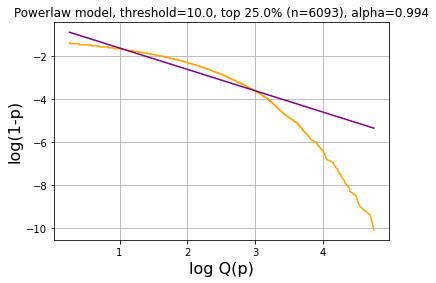

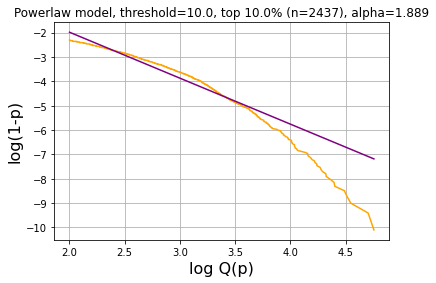

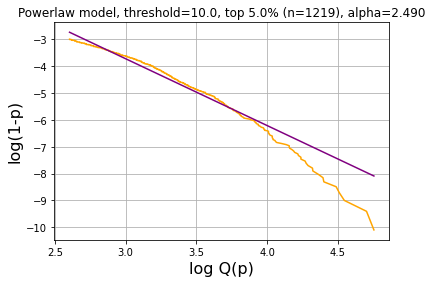

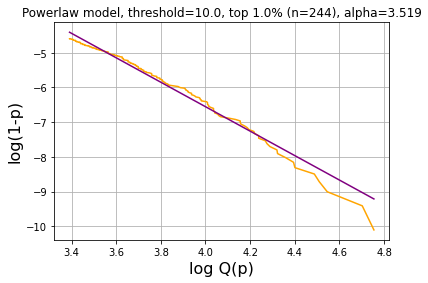

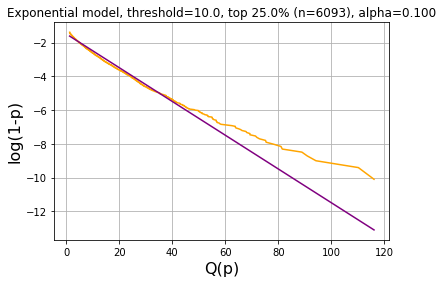

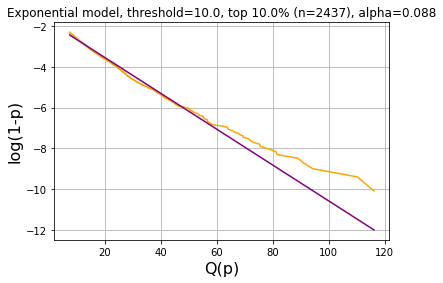

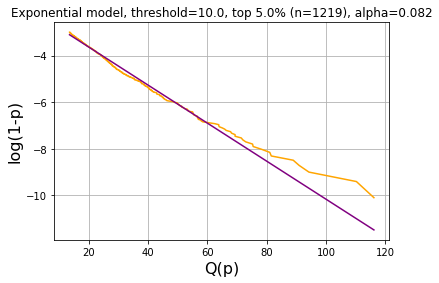

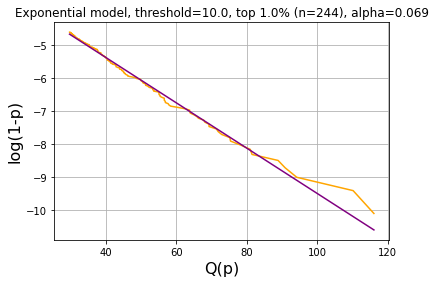

In [87]:
for family in ["powerlaw", "exponential"]:
    for p0 in [0.25, 0.1, 0.05, 0.01]:
        plot_tails(df["PRCP"], p0, thresh, family)
        plt.show()

Below is a "Hill plot" suggesting that the tail index might be around 3.

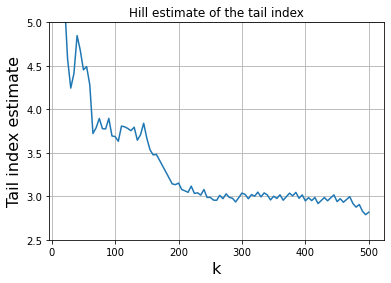

In [88]:
plot_hill(df["PRCP"])

Next we fit generalized extreme value distributions to the block (annual) maxima.  The m-returns based on the GEV model are printed and a qq-plot showing the goodness of fit of the GEV to the data is displayed.

   Years      Return
0     10   77.265260
1    100  128.083204
2    500  178.715938
3   1000  205.734056


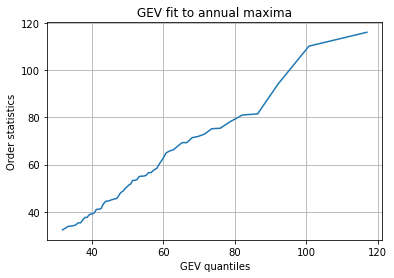

In [89]:
gev = block_max(df)

Below is the shape parameter of the best-fitting GEV to the block maxima.  Due to the parameterization of the GEV used by Scipy, the tail index is -1/shape.

In [90]:
gev.args

(-0.19008398255736259,)

In [91]:
-1/gev.args[0]

5.260832535946184

Fit generalized Pareto models to the exceedances

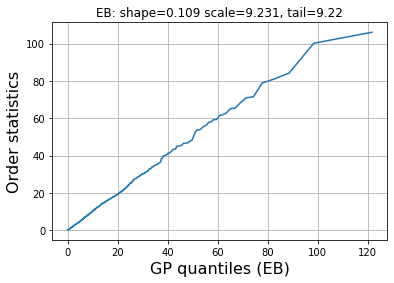

In [92]:
eb = eb_analysis(df["PRCP"], thresh)

Next we calculate m-observation returns based on an exponential and a generalized Pareto model fit to the 24 hour rainfall totals.

In [93]:
yr = np.r_[1, 10, 100, 500, 1000]
cfg = [("exponential", None), ("generalizedpareto", eb)]
for (f,g) in cfg:
    print("\nReturns based on %s:" % f)
    mr = mobs_return(df["PRCP"], 365 * yr, thresh, family=f, gp=g)
    rr = pd.DataFrame({"Years": yr, "MR": mr})
    print(rr)


Returns based on exponential:
Mean = 10.35
   Years          MR
0      1   44.009454
1     10   67.837858
2    100   91.666262
3    500  108.321601
4   1000  115.494666

Returns based on generalizedpareto:
Shape=0.11
Scale=9.23
   Years          MR
0      1   46.450421
1     10   80.943124
2    100  125.226814
3    500  163.448352
4   1000  182.080727


The cell below is a simple demonstration of how to use the gp_estimate function defined above.  Note that there are different parameterizations of the generalized Pareto distribution (this is true of many probability distributions).  Since we are using [scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.genpareto.html), here we use the parameterization adopted by scipy, which is also the parameterization shown on [wikipedia](https://en.wikipedia.org/wiki/Generalized_Pareto_distribution).  The shape parameter $\xi$ is the reciprocal of the tail index $\alpha$, i.e. $\alpha = 1/\xi$.

In [94]:
shape = 1/3.
scale = 1

# Generate data and obtain an estimated GPD using the empirical Bayes approach.
eb, z = check_gp_estimate(shape=shape, scale=scale, thresh=0)

# Check that the population and sample medians match (if they don't something is wrong)
print("Sample median =", np.median(z))
print("Population median =", scale*(2**shape - 1) / shape)

# The fitted GPD has this shape parameter
print("Fitted GPD shape parameter: ", eb.args)

# This is the estimated tail index
print("Estimated tail index: ", 1 / eb.args[0])
print("Population tail index: ", 1 / shape)

Sample median = 0.7730723419907854
Population median = 0.7797631496846196
Fitted GPD shape parameter:  (0.3443618267237561,)
Estimated tail index:  2.9039223351611234
Population tail index:  3.0
